In [1]:
%pip install shap
!pip install kmodes
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import shap
from kmodes.kmodes import KModes
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

Note: you may need to restart the kernel to use updated packages.


In [2]:
Individuos = pd.read_csv(r'C:/Users/jlope/Documents/Maestría en Ingeniería - Analítica/Tesis/Modelos/BDIndividuosTotal.csv',decimal=',')
Individuos

,S_1,I_6,I_7,I_8,I_9,I_10,I_19,I_21_1,I_21_2,I_21_3,...,I_91_10,I_30,I_41,I_44,I_45,I_47,Condiciones Territoriales,Prácticas,Efectos,IPCM
0,1,Femenino,1985,Sin pertenencia étnica,Desplazados o víctima del Conflicto Armado,Básica Secundaria,Si,No,No,No,...,No,Si,No,Si,Si,Mejorado,0.361794798490289,0.387014340398247,0.44463337516526,0.4
1,1,Masculino,1953,Sin pertenencia étnica,Ninguno,Básica Primaria,No,No,Si,No,...,Si,Si,Si,Si,No,Mejorado,0.327151236848329,0.461778890169669,0.238168161836116,0.33
2,1,Femenino,1970,Sin pertenencia étnica,Desplazados o víctima del Conflicto Armado,Ninguno,No,No,No,No,...,No,Si,No,No,No,Empeorado,0.299800315453029,0.372016686965189,0.673631667238401,0.42
3,1,Femenino,1989,Sin pertenencia étnica,Desplazados o víctima del Conflicto Armado,Básica Secundaria,Si,No,No,No,...,No,Si,No,Si,No,Mejorado,0.558784023179863,0.633541759101517,0.323002606500402,0.49
4,1,Femenino,1953,Mestizo,Ninguno,Ninguno,Si,No,No,No,...,No,No,No,Si,No,Permanecen iguales,0.250182909249344,0.521447482222032,0.238168161836116,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11356,12,Hombre,1999,No se identifica con ninguno de los anteriores,Ninguna,Básica secundaria,No,No,No,No,...,No,Si,No,No,No,Permanecen iguales,0.21317564171051,0.439428896142171,0.30527580531839,0.305801439570261
11357,12,Hombre,1994,Mestizo,Ninguna,Básica secundaria,No,No,No,No,...,No,No,No,No,No,Permanecen iguales,0.194827985413158,0.879479847931544,0.315275008033687,0.378026512143469
11358,12,Hombre,1968,No se identifica con ninguno de los anteriores,Ninguna,Básica secundaria,No,No,No,No,...,No,Si,No,Si,No,Permanecen iguales,0.532416558719664,0.481449785781779,0.311142120812354,0.430447761005128
11359,12,Hombre,1998,No se identifica con ninguno de los anteriores,Ninguna,Básica secundaria,No,No,No,No,...,No,No,No,No,No,Mejorado,0.548475866469842,0.593568976891309,0.354381149153931,0.486817792953296


In [3]:
Condiciones = Individuos[[#'S_1', 'I_6', 'I_7', 'I_8', 'I_9', 'I_10',
          "I_19",	"I_21_1",	"I_21_2",	"I_21_3", "I_22",	"I_23",	"I_24",	"I_26_1",	"I_26_2","I_26_3", "I_27",	"I_28_1", "I_29",
          "I_32",	"I_33",	"I_40_1", "I_40_2", "I_40_3", "I_40_4", "I_40_5",	"I_90_1", "I_90_2","I_90_3","I_90_4","I_90_5","I_90_6","I_90_7",
          "I_90_8","I_90_9","I_90_10",
          'Condiciones Territoriales']]
Condiciones = Condiciones.dropna()
# Condiciones.to_excel('CondicionesIPCM.xlsx', index=False)
Condiciones

,I_19,I_21_1,I_21_2,I_21_3,I_22,I_23,I_24,I_26_1,I_26_2,I_26_3,...,I_90_2,I_90_3,I_90_4,I_90_5,I_90_6,I_90_7,I_90_8,I_90_9,I_90_10,Condiciones Territoriales
0,Si,No,No,No,No,No,Adecuadas,No,Si,No,...,No,Si,No,No,Si,No,Si,No,No,0.361794798490289
1,No,No,Si,No,Si,Si,Regulares,Si,Si,No,...,Si,Si,No,No,Si,Si,Si,Si,Si,0.327151236848329
2,No,No,No,No,No,No,Inadecuadas,Si,No,No,...,Si,Si,No,Si,No,No,Si,No,No,0.299800315453029
3,Si,No,No,No,No,No,Regulares,No,No,No,...,No,Si,Si,Si,Si,No,Si,No,No,0.558784023179863
4,Si,No,No,No,No,No,Adecuadas,No,No,No,...,No,Si,No,No,Si,No,Si,No,No,0.250182909249344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11356,No,No,No,No,No,No,Sin registro,No,No,No,...,No,No,Si,No,No,No,No,No,No,0.21317564171051
11357,No,No,No,No,No,No,Sin registro,No,No,No,...,No,No,No,No,No,No,No,No,No,0.194827985413158
11358,No,No,No,No,No,No,Sin registro,No,No,No,...,No,No,No,No,No,No,No,No,No,0.532416558719664
11359,No,No,No,No,No,No,Sin registro,No,No,No,...,No,No,Si,No,No,No,No,Si,No,0.548475866469842


In [4]:
Cond = np.array(Condiciones.drop(['Condiciones Territoriales'],1))
feature_names = Condiciones.drop(['Condiciones Territoriales'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.float64)
ordinalEncoder.fit(Cond)
Cond = ordinalEncoder.transform(Cond)
Cond = pd.DataFrame(Cond, columns=feature_names)
Cond['Condiciones Territoriales'] = Condiciones['Condiciones Territoriales'].astype(float)
Cond['Condiciones Territoriales'] = Cond['Condiciones Territoriales'].replace(np.nan, 0.0, regex=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [5]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(Cond.iloc[:,1:])
Cond["Clase"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2997, cost: 112218.0
Run 1, iteration: 2/100, moves: 87, cost: 112218.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3585, cost: 112419.0
Run 2, iteration: 2/100, moves: 306, cost: 112419.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3251, cost: 111327.0
Run 3, iteration: 2/100, moves: 263, cost: 111327.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3297, cost: 112090.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3759, cost: 113192.0
Run 5, iteration: 2/100, moves: 409, cost: 113192.0
Best run was number 3


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


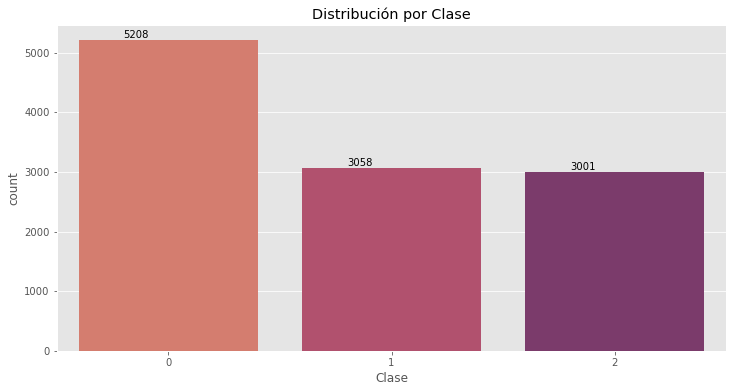

In [6]:
plt.style.use('ggplot')
Frecuencia = Cond.groupby('Clase').sum()
plt.figure(figsize=(12,6))
graf = sns.countplot(Cond['Clase'],palette='flare')
plt.title('Distribución por Clase')
for p in graf.patches:
    graf.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', color='black', size=10)
plt.show()

In [7]:
X = np.array(Cond.drop(['Clase','Condiciones Territoriales'],1))
Y = np.array(Cond['Clase'])
feature_names = Cond.drop(['Clase','Condiciones Territoriales'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
feature_names

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


array(['I_19', 'I_21_1', 'I_21_2', 'I_21_3', 'I_22', 'I_23', 'I_24',
       'I_26_1', 'I_26_2', 'I_26_3', 'I_27', 'I_28_1', 'I_29', 'I_32',
       'I_33', 'I_40_1', 'I_40_2', 'I_40_3', 'I_40_4', 'I_40_5', 'I_90_1',
       'I_90_2', 'I_90_3', 'I_90_4', 'I_90_5', 'I_90_6', 'I_90_7',
       'I_90_8', 'I_90_9', 'I_90_10'], dtype=object)

In [8]:
X = pd.DataFrame(X, columns=feature_names)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [14]:
rfc = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=skf, verbose=1,n_jobs=-1).fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [15]:
print("Mejores parámetros", gs_rfc.best_params_)
print("Mejor estimador", gs_rfc.best_estimator_)

Mejores parámetros {'max_features': 'log2', 'n_estimators': 700}
Mejor estimador RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=700)


In [16]:
rfc = RandomForestClassifier(max_features= 'log2', n_estimators= 700, class_weight='balanced')

rfc.fit(X_train,y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_pred

array([0, 2, 0, ..., 1, 0, 2], dtype=uint16)

In [17]:
matriz_rfc = confusion_matrix(y_test, rfc_y_pred)
print('Matriz de Confusión:')
print(matriz_rfc)

Matriz de Confusión:
[[1582   18   24]
 [  30  846   42]
 [  30   56  753]]


Text(0.5, 15.0, 'Predicción')

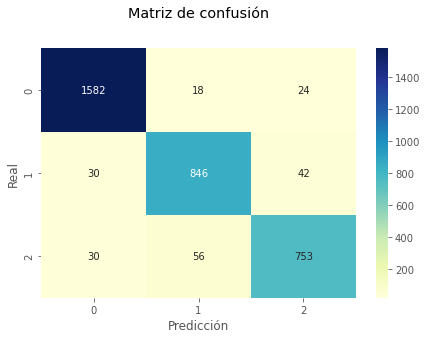

In [18]:
sns.heatmap(pd.DataFrame(matriz_rfc), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [19]:
precision_rfc = precision_score(y_test, rfc_y_pred,average='micro')
print('Precisión del modelo:')
print(precision_rfc)

accuracy_rfc = accuracy_score(y_test, rfc_y_pred)
print('Exactitud del modelo:')
print(accuracy_rfc)

Precisión del modelo:
0.9408459035788228
Exactitud del modelo:
0.9408459035788228


In [20]:
clas_rfc = classification_report(y_test, rfc_y_pred, zero_division = 1)
print(clas_rfc)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1624
           1       0.92      0.92      0.92       918
           2       0.92      0.90      0.91       839

    accuracy                           0.94      3381
   macro avg       0.93      0.93      0.93      3381
weighted avg       0.94      0.94      0.94      3381



In [21]:
rfc.feature_importances_

array([0.01228751, 0.00862148, 0.0572091 , 0.0104144 , 0.06319904,
       0.06382963, 0.02721525, 0.01187822, 0.03780474, 0.01147713,
       0.0069492 , 0.00468743, 0.0074103 , 0.01625184, 0.01585385,
       0.0437399 , 0.04843707, 0.02194563, 0.02162989, 0.05387423,
       0.05740634, 0.04229202, 0.03658539, 0.04264595, 0.03130516,
       0.03735093, 0.04684096, 0.02851592, 0.06503192, 0.06730959])

Text(0.5, 0, 'Random Forest Feature Importance')

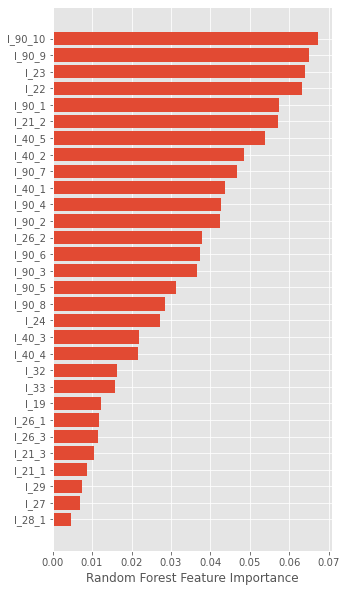

In [22]:
plt.rcParams["figure.figsize"] = (5, 10)
variables_importantes = rfc.feature_importances_.argsort()
plt.barh(feature_names[variables_importantes], rfc.feature_importances_[variables_importantes])
plt.xlabel("Random Forest Feature Importance")

In [23]:
perm_importance = permutation_importance(rfc, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

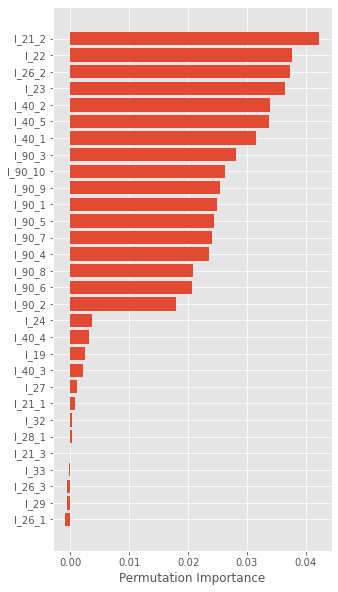

In [24]:
Variables_permutadas = perm_importance.importances_mean.argsort()
plt.barh(feature_names[Variables_permutadas], perm_importance.importances_mean[Variables_permutadas])
plt.xlabel("Permutation Importance")

In [25]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

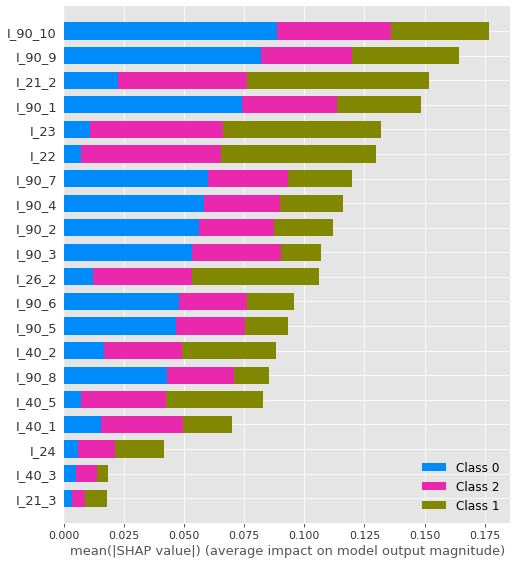

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

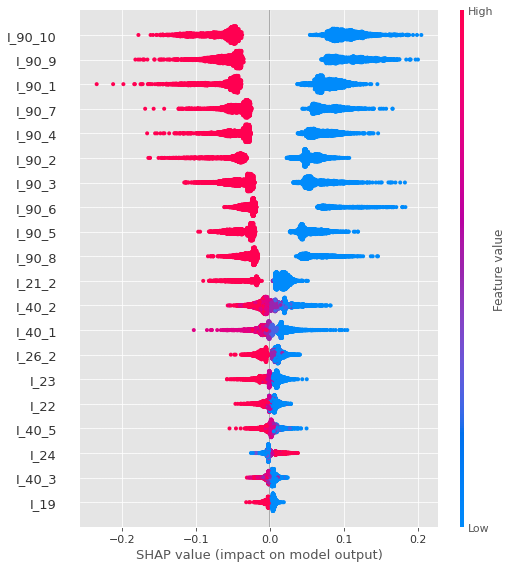

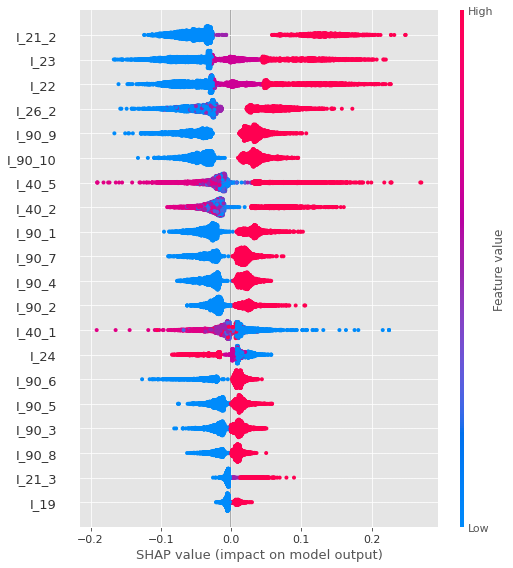

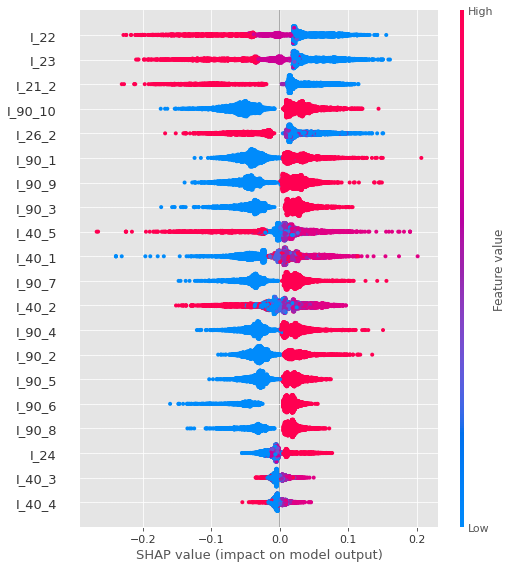

In [27]:
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[2], X_test)

In [28]:
Practicas = Individuos[[#'S_1', 'I_6', 'I_7', 'I_8', 'I_9', 'I_10',
          "I_31",	"I_35_1", "I_38",	"I_51_2", "I_51_3",	"I_51_4",	"I_52",	"I_54", "I_55",	"I_48_1", "I_48_2", "I_48_3", "I_48_4", "I_48_5",
          "I_48_6","I_48_7","I_48_8","I_48_9", "I_91_1","I_91_2","I_91_3","I_91_4","I_91_5","I_91_6","I_91_7","I_91_8","I_91_9","I_91_10",
          'Prácticas']]
Practicas = Practicas.dropna()
# Individuos.to_excel('IndividuosIPCM.xlsx', index=False)
Practicas

,I_31,I_35_1,I_38,I_51_2,I_51_3,I_51_4,I_52,I_54,I_55,I_48_1,...,I_91_2,I_91_3,I_91_4,I_91_5,I_91_6,I_91_7,I_91_8,I_91_9,I_91_10,Prácticas
0,Si,No se han presentado conflictos,Si,De acuerdo,En desacuerdo,En desacuerdo,Si,No,No,4,...,No,Si,No,No,Si,No,No,No,No,0.387014340398247
1,Si,No se han presentado conflictos,No,Totalmente desacuerdo,Totalmente desacuerdo,Totalmente desacuerdo,Si,Si,Si,3,...,Si,Si,No,No,No,Si,No,No,Si,0.461778890169669
2,No,No pertenezco a ninguna organización,No,En desacuerdo,De acuerdo,En desacuerdo,Si,No,No,3,...,No,Si,No,Si,No,No,Si,No,No,0.372016686965189
3,Si,No se han presentado conflictos,No,"Ni de acuerdo, ni en desacuerdo","Ni de acuerdo, ni en desacuerdo","Ni de acuerdo, ni en desacuerdo",No,Si,Si,3,...,No,No,No,No,Si,No,Si,No,No,0.633541759101517
4,No,No se han presentado conflictos,Si,De acuerdo,De acuerdo,De acuerdo,Si,No,No,3,...,No,No,No,No,Si,No,Si,No,No,0.521447482222032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11356,Si,No se han presentado conflictos,No,En desacuerdo,En desacuerdo,En desacuerdo,No,No,No,1,...,No,No,No,No,No,No,No,No,No,0.439428896142171
11357,No,No se han presentado conflictos,No,Totalmente de acuerdo,Totalmente de acuerdo,Totalmente de acuerdo,No,No,No,1,...,No,No,No,No,No,No,No,No,No,0.879479847931544
11358,No,No se han presentado conflictos,No,"Ni de acuerdo, ni en desacuerdo",Totalmente de acuerdo,Totalmente desacuerdo,No,Si,Si,1,...,No,No,No,No,No,No,No,No,No,0.481449785781779
11359,No,No se han presentado conflictos,No,"Ni de acuerdo, ni en desacuerdo","Ni de acuerdo, ni en desacuerdo","Ni de acuerdo, ni en desacuerdo",No,No,No,5,...,No,No,Si,No,No,No,No,No,No,0.593568976891309


In [30]:
Prac = np.array(Practicas.drop(['Prácticas'],1))
feature_names = Practicas.drop(['Prácticas'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.float64)
ordinalEncoder.fit(Prac)
Prac = ordinalEncoder.transform(Prac)
Prac = pd.DataFrame(Prac, columns=feature_names)
Prac['Prácticas'] = Practicas['Prácticas'].astype(float)
Prac['Prácticas'] = Prac['Prácticas'].replace(np.nan, 0.0, regex=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [31]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(Prac.iloc[:,1:])
Prac["Clase"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3490, cost: 106617.0
Run 1, iteration: 2/100, moves: 715, cost: 106217.0
Run 1, iteration: 3/100, moves: 95, cost: 106217.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2754, cost: 104249.0
Run 2, iteration: 2/100, moves: 639, cost: 104249.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3726, cost: 109480.0
Run 3, iteration: 2/100, moves: 8, cost: 109480.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2854, cost: 111292.0
Run 4, iteration: 2/100, moves: 599, cost: 110710.0
Run 4, iteration: 3/100, moves: 1597, cost: 107141.0
Run 4, iteration: 4/100, moves: 676, cost: 106615.0
Run 4, iteration: 5/100, moves: 574, cost: 106615.0
Init: initializing centroids
Init: initializing cluste

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


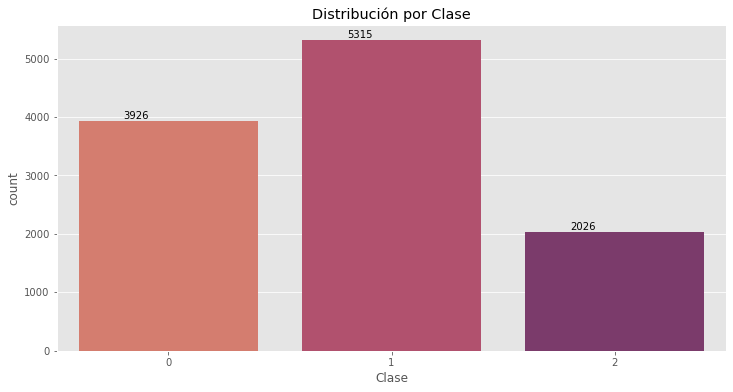

In [33]:
plt.style.use('ggplot')
Frecuencia = Prac.groupby('Clase').sum()
plt.figure(figsize=(12,6))
graf = sns.countplot(Prac['Clase'],palette='flare')
plt.title('Distribución por Clase')
for p in graf.patches:
    graf.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', color='black', size=10)
plt.show()

In [34]:
X = np.array(Prac.drop(['Clase','Prácticas'],1))
Y = np.array(Prac['Clase'])
feature_names = Prac.drop(['Clase','Prácticas'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
feature_names

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


array(['I_31', 'I_35_1', 'I_38', 'I_51_2', 'I_51_3', 'I_51_4', 'I_52',
       'I_54', 'I_55', 'I_48_1', 'I_48_2', 'I_48_3', 'I_48_4', 'I_48_5',
       'I_48_6', 'I_48_7', 'I_48_8', 'I_48_9', 'I_91_1', 'I_91_2',
       'I_91_3', 'I_91_4', 'I_91_5', 'I_91_6', 'I_91_7', 'I_91_8',
       'I_91_9', 'I_91_10'], dtype=object)

In [35]:
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.float64)

ordinalEncoder.fit(X)

X = ordinalEncoder.transform(X)

In [36]:
X = pd.DataFrame(X, columns=feature_names)

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [39]:
rfc = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=skf, verbose=1,n_jobs=-1).fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [40]:
print("Mejores parámetros", gs_rfc.best_params_)
print("Mejor estimador", gs_rfc.best_estimator_)

Mejores parámetros {'max_features': 'log2', 'n_estimators': 500}
Mejor estimador RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=500)


In [41]:
rfc = RandomForestClassifier(max_features= 'log2', n_estimators= 500, class_weight='balanced')

rfc.fit(X_train,y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_pred

array([2, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [42]:
matriz_rfc = confusion_matrix(y_test, rfc_y_pred)
print('Matriz de Confusión:')
print(matriz_rfc)

Matriz de Confusión:
[[1100   90   18]
 [  49 1512   19]
 [   7   25  561]]


Text(0.5, 24.0, 'Predicción')

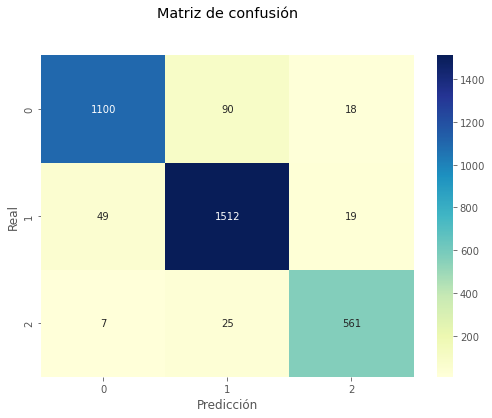

In [43]:
plt.rcParams["figure.figsize"] = (7, 5)
sns.heatmap(pd.DataFrame(matriz_rfc), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [44]:
precision_rfc = precision_score(y_test, rfc_y_pred,average='micro')
print('Precisión del modelo:')
print(precision_rfc)

accuracy_rfc = accuracy_score(y_test, rfc_y_pred)
print('Exactitud del modelo:')
print(accuracy_rfc)

Precisión del modelo:
0.9384797397219757
Exactitud del modelo:
0.9384797397219757


In [45]:
clas_rfc = classification_report(y_test, rfc_y_pred, zero_division = 1)
print(clas_rfc)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1208
           1       0.93      0.96      0.94      1580
           2       0.94      0.95      0.94       593

    accuracy                           0.94      3381
   macro avg       0.94      0.94      0.94      3381
weighted avg       0.94      0.94      0.94      3381



In [46]:
rfc.feature_importances_

array([0.01070398, 0.01047798, 0.00559409, 0.02892099, 0.03333323,
       0.02892191, 0.02652289, 0.03290843, 0.02384667, 0.04685364,
       0.07260535, 0.07630461, 0.1054944 , 0.08360379, 0.06855796,
       0.10682092, 0.06592958, 0.12553934, 0.00463151, 0.00351319,
       0.00503197, 0.00555598, 0.00487345, 0.00567787, 0.00429687,
       0.00465697, 0.00498468, 0.00383775])

Text(0.5, 0, 'Random Forest Feature Importance')

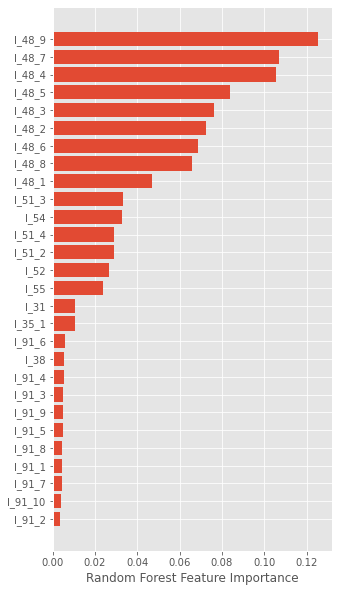

In [47]:
plt.rcParams["figure.figsize"] = (5, 10)
variables_importantes = rfc.feature_importances_.argsort()
plt.barh(feature_names[variables_importantes], rfc.feature_importances_[variables_importantes])
plt.xlabel("Random Forest Feature Importance")

In [48]:
perm_importance = permutation_importance(rfc, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

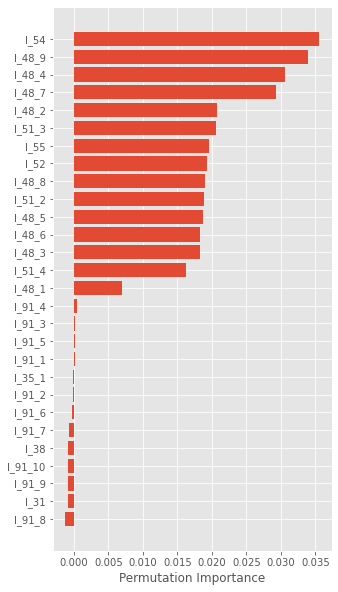

In [49]:
Variables_permutadas = perm_importance.importances_mean.argsort()
plt.barh(feature_names[Variables_permutadas], perm_importance.importances_mean[Variables_permutadas])
plt.xlabel("Permutation Importance")

In [50]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

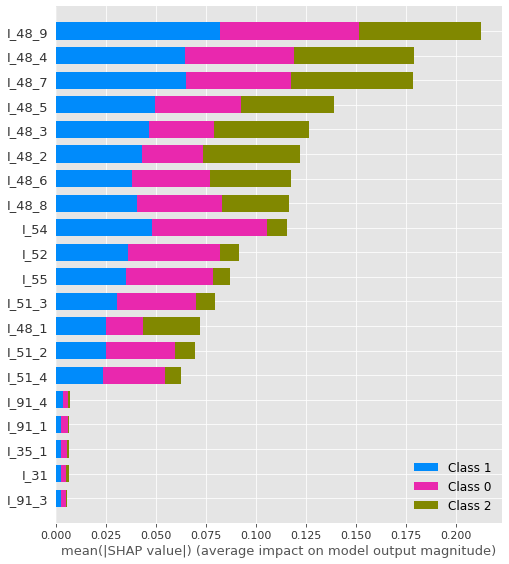

In [51]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

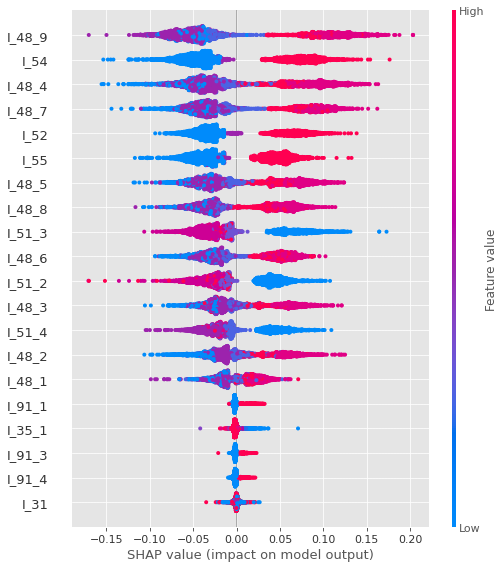

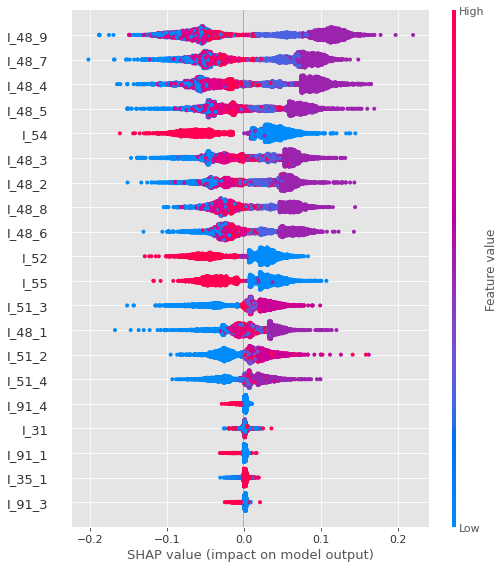

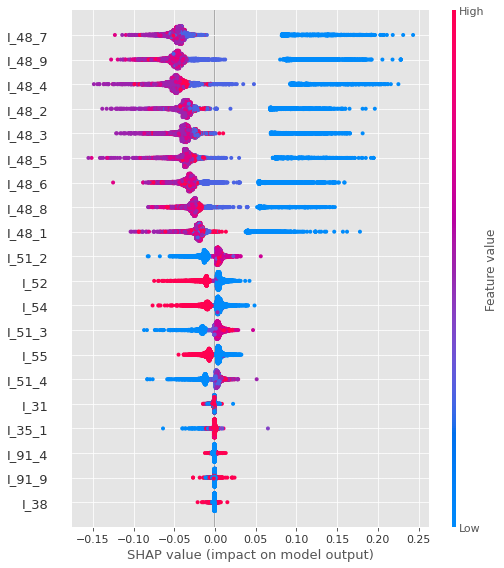

In [52]:
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[2], X_test)

In [53]:
Efectos = Individuos[[#'S_1', 'I_6', 'I_7', 'I_8', 'I_9', 'I_10',
          "I_30",	"I_41",	"I_44",	"I_45","I_47",
          'Efectos']]
Efectos = Efectos.dropna()

Efectos 

,I_30,I_41,I_44,I_45,I_47,Efectos
0,Si,No,Si,Si,Mejorado,0.44463337516526
1,Si,Si,Si,No,Mejorado,0.238168161836116
2,Si,No,No,No,Empeorado,0.673631667238401
3,Si,No,Si,No,Mejorado,0.323002606500402
4,No,No,Si,No,Permanecen iguales,0.238168161836116
...,...,...,...,...,...,...
11356,Si,No,No,No,Permanecen iguales,0.30527580531839
11357,No,No,No,No,Permanecen iguales,0.315275008033687
11358,Si,No,Si,No,Permanecen iguales,0.311142120812354
11359,No,No,No,No,Mejorado,0.354381149153931


In [55]:
Efec = np.array(Efectos.drop(['Efectos'],1))
feature_names = Efectos.drop(['Efectos'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.float64)
ordinalEncoder.fit(Efec)
Efec = ordinalEncoder.transform(Efec)
Efec = pd.DataFrame(Efec, columns=feature_names)
Efec['Efectos'] = Efectos['Efectos'].astype(float)
Efec['Efectos'] = Efec['Efectos'].replace(np.nan, 0.0, regex=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [56]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(Efec.iloc[:,1:])
Efec["Clase"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1627, cost: 20589.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 21156.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3159, cost: 19071.0
Run 3, iteration: 2/100, moves: 6, cost: 19071.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 974, cost: 21957.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 50, cost: 21845.0
Best run was number 3


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


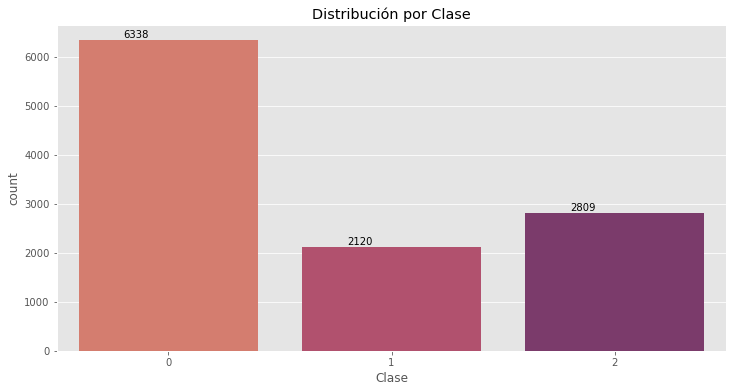

In [59]:
plt.style.use('ggplot')
Frecuencia = Efec.groupby('Clase').sum()
plt.figure(figsize=(12,6))
graf = sns.countplot(Efec['Clase'],palette='flare')
plt.title('Distribución por Clase')
for p in graf.patches:
    graf.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', color='black', size=10)
plt.show()

In [60]:
X = np.array(Efec.drop(['Clase','Efectos'],1))
Y = np.array(Efec['Clase'])
feature_names = Efec.drop(['Clase','Efectos'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
feature_names

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


array(['I_30', 'I_41', 'I_44', 'I_45', 'I_47'], dtype=object)

In [61]:
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.float64)

ordinalEncoder.fit(X)

X = ordinalEncoder.transform(X)

In [62]:
X = pd.DataFrame(X, columns=feature_names)

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [64]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [65]:
rfc = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=skf, verbose=1, n_jobs=-1).fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [66]:
print("Mejores parámetros", gs_rfc.best_params_)
print("Mejor estimador", gs_rfc.best_estimator_)

Mejores parámetros {'max_features': 'auto', 'n_estimators': 100}
Mejor estimador RandomForestClassifier(class_weight='balanced')


In [67]:
rfc = RandomForestClassifier(max_features= 'auto', n_estimators= 100, class_weight='balanced')

rfc.fit(X_train,y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_pred

array([1, 2, 0, ..., 0, 2, 0], dtype=uint16)

In [68]:
matriz_rfc = confusion_matrix(y_test, rfc_y_pred)
print('Matriz de Confusión:')
print(matriz_rfc)

Matriz de Confusión:
[[1894    4    3]
 [  62  563    0]
 [  16    1  838]]


Text(0.5, 24.0, 'Predicción')

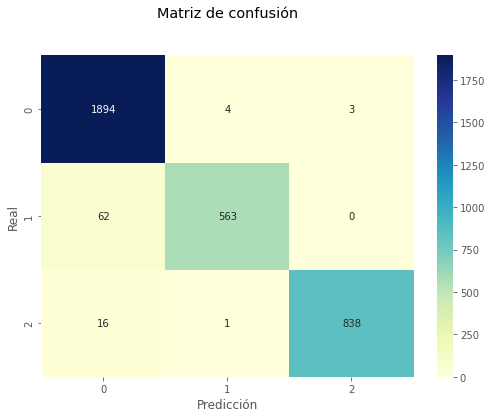

In [69]:
plt.rcParams["figure.figsize"] = (7, 5)
sns.heatmap(pd.DataFrame(matriz_rfc), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [70]:
precision_rfc = precision_score(y_test, rfc_y_pred,average='micro')
print('Precisión del modelo:')
print(precision_rfc)

accuracy_rfc = accuracy_score(y_test, rfc_y_pred)
print('Exactitud del modelo:')
print(accuracy_rfc)

Precisión del modelo:
0.9745637385388938
Exactitud del modelo:
0.9745637385388938


In [71]:
clas_rfc = classification_report(y_test, rfc_y_pred, zero_division = 1)
print(clas_rfc)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1901
           1       0.99      0.90      0.94       625
           2       1.00      0.98      0.99       855

    accuracy                           0.97      3381
   macro avg       0.98      0.96      0.97      3381
weighted avg       0.98      0.97      0.97      3381



In [72]:
rfc.feature_importances_

array([0.00444195, 0.38501508, 0.27333147, 0.02488293, 0.31232857])

Text(0.5, 0, 'Random Forest Feature Importance')

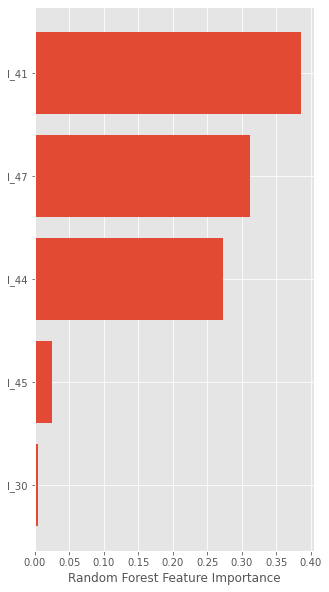

In [73]:
plt.rcParams["figure.figsize"] = (5, 10)
variables_importantes = rfc.feature_importances_.argsort()
plt.barh(feature_names[variables_importantes], rfc.feature_importances_[variables_importantes])
plt.xlabel("Random Forest Feature Importance")

In [74]:
perm_importance = permutation_importance(rfc, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

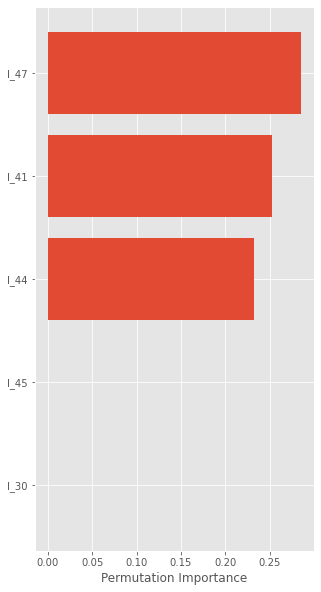

In [75]:
Variables_permutadas = perm_importance.importances_mean.argsort()
plt.barh(feature_names[Variables_permutadas], perm_importance.importances_mean[Variables_permutadas])
plt.xlabel("Permutation Importance")

In [76]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

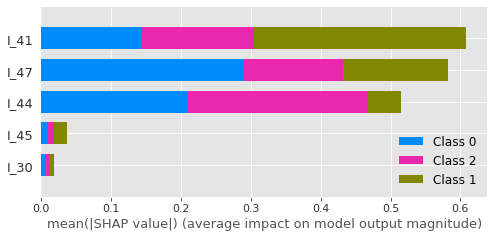

In [77]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

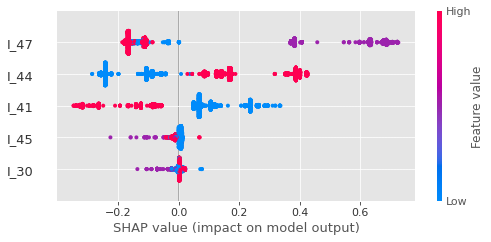

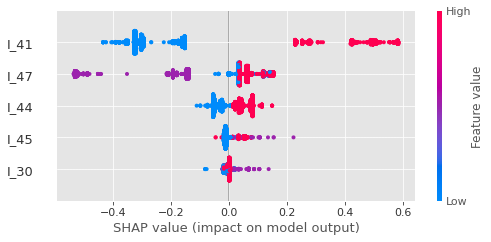

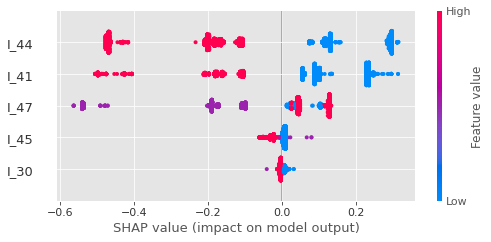

In [78]:
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[2], X_test)

In [81]:
Organizaciones = pd.read_csv(r'C:/Users/jlope/Documents/Maestría en Ingeniería - Analítica/Tesis/Modelos/BDOrganizacionesTotal.csv',decimal=',')
Condiciones = Organizaciones[["O_88","O_89",
                 "O_12","O_13","O_22","O_67","O_68","O_8","O_19_1","O_19_2","O_19_3","O_19_4","O_19_5","O_19_6","O_19_7","O_19_8","O_19_9", 
                 "O_20_1","O_20_2","O_20_3","O_20_4","O_20_5","O_20_6","O_20_7","O_20_8","O_70",
                 "O_71",	"O_72_1","O_72_2","O_72_3","O_72_4","O_72_5","O_72_6","O_72_7","O_72_8","O_72_9",
                 'Condiciones Territoriales']]
Condiciones

,O_88,O_89,O_12,O_13,O_22,O_67,O_68,O_8,O_19_1,O_19_2,...,O_72_1,O_72_2,O_72_3,O_72_4,O_72_5,O_72_6,O_72_7,O_72_8,O_72_9,Condiciones Territoriales
0,Hombre,Si,Si,No,300,No consulta,No consulta,No,No,No,...,No,No,No,No,No,No,No,No,Si,0.82450031473885
1,Mujer,No,Si,Si,50,No consulta,No consulta,Si,No,No,...,No,No,No,No,No,No,No,No,Si,0.734871050717431
2,Hombre,No,Si,Si,3000,Algunas veces,Casi siempre,Si,No,No,...,No,No,No,No,No,No,No,Si,No,0.547073739855052
3,Mujer,No,Si,Si,30,No consulta,No consulta,Si,No,No,...,No,No,No,No,No,No,No,No,Si,0.763295432322538
4,Mujer,Si,Si,Si,12,Algunas veces,Algunas veces,Si,No,No,...,No,No,No,No,No,Si,Si,No,No,0.629710009630137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,Hombre,Si,No,No,50,No consulta,No consulta,No,No,No,...,No,No,No,No,No,No,No,No,Si,0.604451749658143
2835,Hombre,No,No,No,49,No consulta,No consulta,No,No,No,...,No,No,No,No,No,No,No,No,Si,0.656681957124342
2836,Hombre,Si,No,No,15,No consulta,No consulta,No,No,No,...,No,No,No,No,No,No,No,No,Si,0.668042477946242
2837,Mujer,Si,No,No,10,No consulta,No consulta,No,No,No,...,No,No,No,No,No,No,No,No,Si,0.685270086412262


In [82]:
Cond = np.array(Condiciones.drop(['Condiciones Territoriales'],1))
feature_names = Condiciones.drop(['Condiciones Territoriales'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.float64)
ordinalEncoder.fit(Cond)
Cond = ordinalEncoder.transform(Cond)
Cond = pd.DataFrame(Cond, columns=feature_names)
Cond['Condiciones Territoriales'] = Condiciones['Condiciones Territoriales'].astype(float)
Cond['Condiciones Territoriales'] = Cond['Condiciones Territoriales'].replace(np.nan, 0.0, regex=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [83]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(Cond.iloc[:,1:])
Cond["Clase"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 665, cost: 29107.0
Run 1, iteration: 2/100, moves: 131, cost: 29107.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 548, cost: 30554.0
Run 2, iteration: 2/100, moves: 410, cost: 30426.0
Run 2, iteration: 3/100, moves: 45, cost: 30426.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 907, cost: 23077.0
Run 3, iteration: 2/100, moves: 271, cost: 23064.0
Run 3, iteration: 3/100, moves: 0, cost: 23064.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 677, cost: 28925.0
Run 4, iteration: 2/100, moves: 210, cost: 28780.0
Run 4, iteration: 3/100, moves: 31, cost: 28780.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 870, cost: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


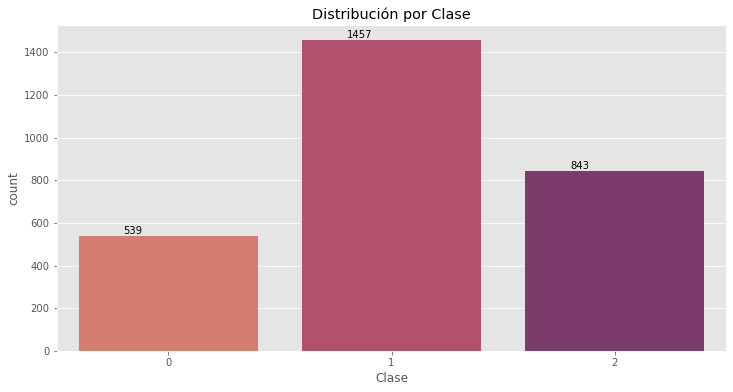

In [84]:
plt.style.use('ggplot')
Frecuencia = Cond.groupby('Clase').sum()
plt.figure(figsize=(12,6))
graf = sns.countplot(Cond['Clase'],palette='flare')
plt.title('Distribución por Clase')
for p in graf.patches:
    graf.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', color='black', size=10)
plt.show()

In [85]:
X = np.array(Cond.drop(['Clase','Condiciones Territoriales'],1))
Y = np.array(Cond['Clase'])
feature_names = Cond.drop([ 'Clase','Condiciones Territoriales'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
feature_names

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


array(['O_88', 'O_89', 'O_12', 'O_13', 'O_22', 'O_67', 'O_68', 'O_8',
       'O_19_1', 'O_19_2', 'O_19_3', 'O_19_4', 'O_19_5', 'O_19_6',
       'O_19_7', 'O_19_8', 'O_19_9', 'O_20_1', 'O_20_2', 'O_20_3',
       'O_20_4', 'O_20_5', 'O_20_6', 'O_20_7', 'O_20_8', 'O_70', 'O_71',
       'O_72_1', 'O_72_2', 'O_72_3', 'O_72_4', 'O_72_5', 'O_72_6',
       'O_72_7', 'O_72_8', 'O_72_9'], dtype=object)

In [86]:
ordinalEncoder = OrdinalEncoder(categories="auto",dtype=np.float64)

ordinalEncoder.fit(X)

X = ordinalEncoder.transform(X)

In [87]:
X = pd.DataFrame(X, columns=feature_names)

In [88]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [89]:
rfc = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=skf, verbose=1, n_jobs=-1).fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [90]:
print("Mejores parámetros", gs_rfc.best_params_)
print("Mejor estimador", gs_rfc.best_estimator_)

Mejores parámetros {'max_features': 'auto', 'n_estimators': 500}
Mejor estimador RandomForestClassifier(class_weight='balanced', n_estimators=500)


In [91]:
rfc = RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=500)

rfc.fit(X_train,y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_pred

array([1, 1, 2, 1, 1, 2, 1, 0, 2, 0, 2, 0, 2, 0, 2, 1, 1, 1, 1, 2, 1, 0,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2,
       1, 0, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1,
       1, 1, 2, 1, 2, 1, 0, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2,
       2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 1,
       0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 1, 2, 1, 2, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1,

In [92]:
matriz_rfc = confusion_matrix(y_test, rfc_y_pred)
print('Matriz de Confusión:')
print(matriz_rfc)

Matriz de Confusión:
[[159   0   0]
 [  2 419   9]
 [  0  22 241]]


Text(0.5, 24.0, 'Predicción')

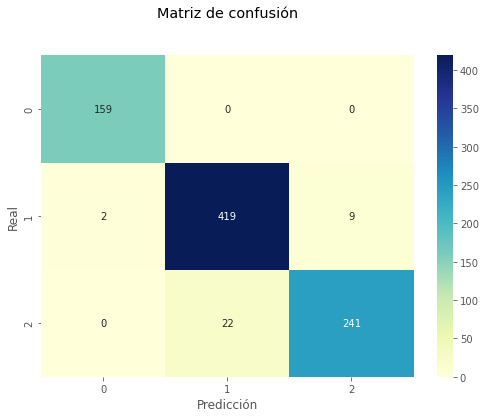

In [93]:
plt.rcParams["figure.figsize"] = (7, 5)
sns.heatmap(pd.DataFrame(matriz_rfc), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [94]:
precision_rfc = precision_score(y_test, rfc_y_pred,average='micro')
print('Precisión del modelo:')
print(precision_rfc)

accuracy_rfc = accuracy_score(y_test, rfc_y_pred)
print('Exactitud del modelo:')
print(accuracy_rfc)

Precisión del modelo:
0.9612676056338029
Exactitud del modelo:
0.9612676056338029


In [95]:
clas_rfc = classification_report(y_test, rfc_y_pred, zero_division = 1)
print(clas_rfc)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       159
           1       0.95      0.97      0.96       430
           2       0.96      0.92      0.94       263

    accuracy                           0.96       852
   macro avg       0.97      0.96      0.97       852
weighted avg       0.96      0.96      0.96       852



In [96]:
rfc.feature_importances_

array([0.00633421, 0.00586942, 0.04861058, 0.05074568, 0.02884767,
       0.05196655, 0.05230296, 0.05083613, 0.00519682, 0.03033266,
       0.01854601, 0.04435801, 0.02487087, 0.06405742, 0.01876381,
       0.00763715, 0.00522185, 0.02967891, 0.0108608 , 0.01363242,
       0.00511819, 0.03807777, 0.0582729 , 0.07977112, 0.03036358,
       0.07228633, 0.03318391, 0.00559278, 0.00736907, 0.00329879,
       0.00421679, 0.00353223, 0.00585812, 0.00680698, 0.05674556,
       0.02083597])

Text(0.5, 0, 'Random Forest Feature Importance')

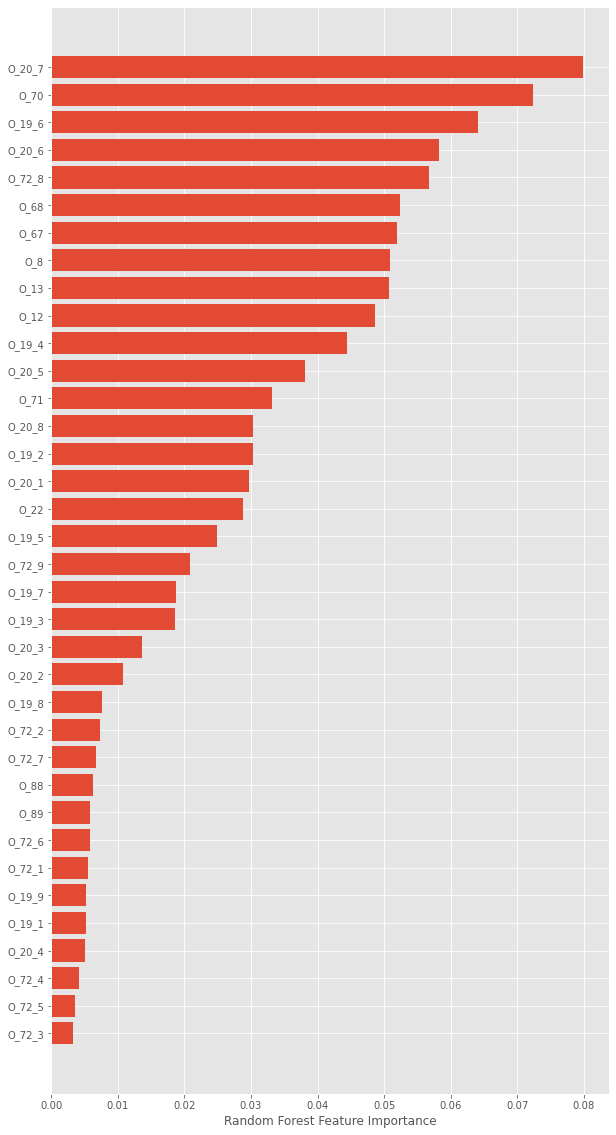

In [97]:
plt.rcParams["figure.figsize"] = (10, 20)
variables_importantes = rfc.feature_importances_.argsort()
plt.barh(feature_names[variables_importantes], rfc.feature_importances_[variables_importantes])
plt.xlabel("Random Forest Feature Importance")

In [98]:
perm_importance = permutation_importance(rfc, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

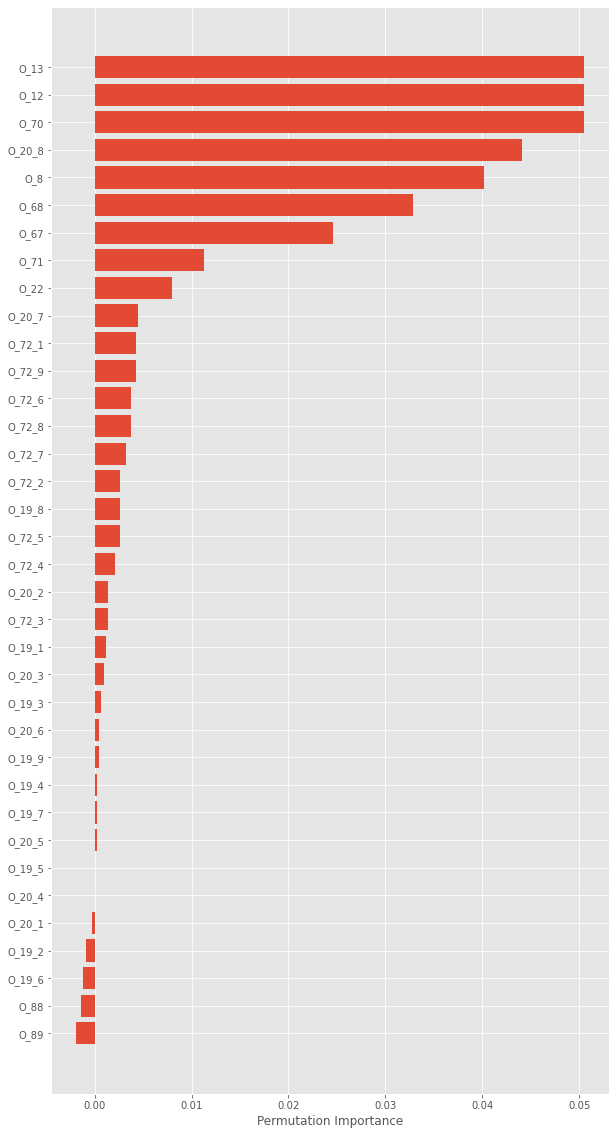

In [99]:
Variables_permutadas = perm_importance.importances_mean.argsort()
plt.barh(feature_names[Variables_permutadas], perm_importance.importances_mean[Variables_permutadas])
plt.xlabel("Permutation Importance")

In [100]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

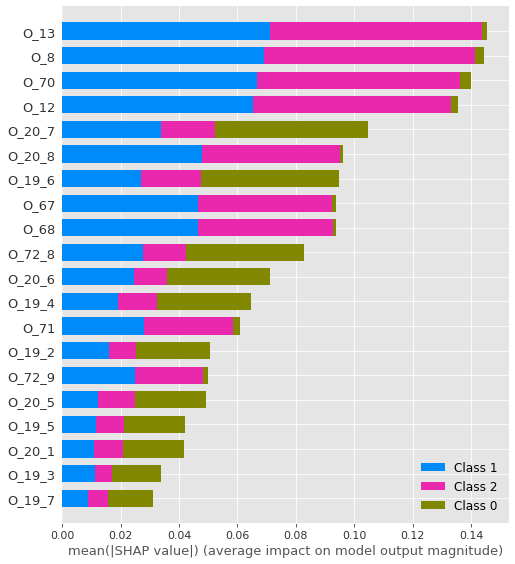

In [101]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

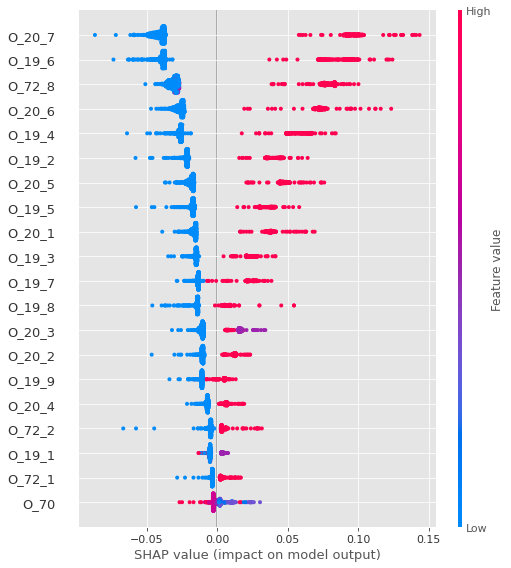

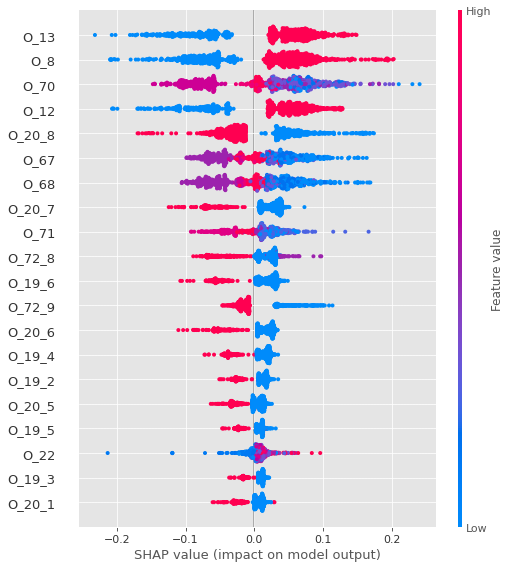

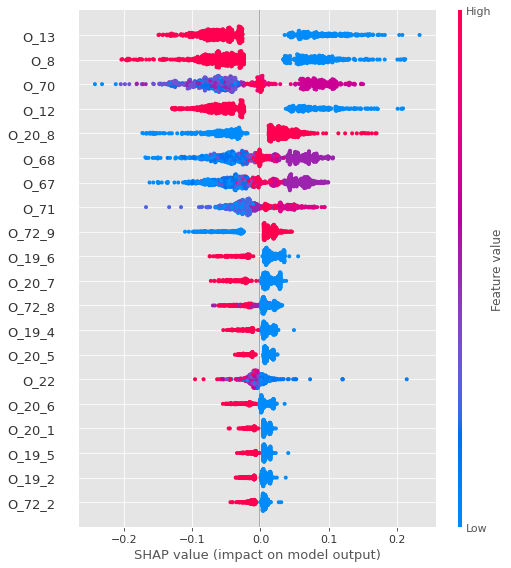

In [102]:
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[2], X_test)

In [104]:
Practicas = Organizaciones[["O_88","O_89",
                "O_24","O_48","O_52","O_54","O_58","O_59","O_90","O_28_1","O_28_2","O_28_3","O_28_4","O_28_5","O_28_6","O_28_7","O_28_8",
                 "O_37_1","O_37_2","O_37_3","O_37_4","O_37_5","O_38_1","O_38_2","O_38_3","O_38_4","O_38_5","O_38_6","O_38_7","O_38_8","O_38_9",
                 "O_66_1","O_66_2","O_66_3","O_66_4","O_66_5","O_66_6","O_66_7","O_81_1","O_81_2","O_81_3","O_81_4","O_81_5","O_81_6","O_81_7",
                 "O_82_1","O_82_2","O_82_3","O_82_4","O_82_5","O_82_6","O_82_7",
                 'Prácticas']]
Practicas

,O_88,O_89,O_24,O_48,O_52,O_54,O_58,O_59,O_90,O_28_1,...,O_81_6,O_81_7,O_82_1,O_82_2,O_82_3,O_82_4,O_82_5,O_82_6,O_82_7,Prácticas
0,Hombre,Si,1,No,1,No,Nunca,Nunca,3,No,...,Cooperativo,Delegativo,Democráctico,Condescendiente,Muy inclusivo,Consultivo,Proactivo,Cooperativo,Autosuficiente,0.772058857086849
1,Mujer,No,0,No,0,No,Nunca,Nunca,1,No,...,Apático,Autosuficiente,Autoritario,Manipulador,Excluyente,Dictatorial,Pasivo,Apático,Autosuficiente,0.80354026372876
2,Hombre,No,32,Si,43,Si,Siempre,Siempre,1,No,...,Muy apático,Muy autosuficiente,Muy democrático,Condescendiente,Muy inclusivo,Muy consultivo,Muy proactivo,Muy cooperativo,Muy delegativo,0.374272301990556
3,Mujer,No,0,Si,12,Si,Casi siempre,Nunca,1,No,...,Apático,Autosuficiente,Autoritario,Manipulador,Excluyente,Dictatorial,Pasivo,Apático,Autosuficiente,0.638823793779116
4,Mujer,Si,0,Si,2,No,Nunca,Nunca,1,No,...,Apático,Autosuficiente,Democráctico,Condescendiente,Inclusivo,Consultivo,Proactivo,Cooperativo,Autosuficiente,0.772366831559398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,Hombre,Si,10,No,0,No,Nunca,Nunca,2,No,...,Cooperativo,Delegativo,Democrático,Condescendiente,Inclusivo,Consultivo,Proactivo,Cooperativo,Delegativo,0.673724075286665
2835,Hombre,No,1,No,2,No,Nunca,Nunca,1,No,...,Cooperativo,Delegativo,Democrático,Condescendiente,Inclusivo,Consultivo,Proactivo,Cooperativo,Delegativo,0.709377034067371
2836,Hombre,Si,0,No,4,No,Nunca,Nunca,6,No,...,Cooperativo,Delegativo,Democrático,Condescendiente,Inclusivo,Consultivo,Proactivo,Cooperativo,Delegativo,0.655933152402854
2837,Mujer,Si,1,No,3,No,Nunca,Nunca,6,No,...,Cooperativo,Delegativo,Democrático,Condescendiente,Inclusivo,Consultivo,Proactivo,Cooperativo,Delegativo,0.654565350551821


In [105]:
Prac = np.array(Practicas.drop(['Prácticas'],1))
feature_names = Practicas.drop(['Prácticas'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.float64)
ordinalEncoder.fit(Prac)
Prac = ordinalEncoder.transform(Prac)
Prac = pd.DataFrame(Prac, columns=feature_names)
Prac['Prácticas'] = Practicas['Prácticas'].astype(float)
Prac['Prácticas'] = Prac['Prácticas'].replace(np.nan, 0.0, regex=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [106]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(Prac.iloc[:,1:])
Prac["Clase"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1110, cost: 44333.0
Run 1, iteration: 2/100, moves: 552, cost: 43404.0
Run 1, iteration: 3/100, moves: 47, cost: 43403.0
Run 1, iteration: 4/100, moves: 0, cost: 43403.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 817, cost: 44750.0
Run 2, iteration: 2/100, moves: 687, cost: 42207.0
Run 2, iteration: 3/100, moves: 270, cost: 41995.0
Run 2, iteration: 4/100, moves: 77, cost: 41995.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 842, cost: 43775.0
Run 3, iteration: 2/100, moves: 311, cost: 43460.0
Run 3, iteration: 3/100, moves: 59, cost: 43460.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 806, cost: 42636.0
Run 4, iteration: 2/100, moves: 345, cost: 42054.0
Run 4, iteration: 3/1

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


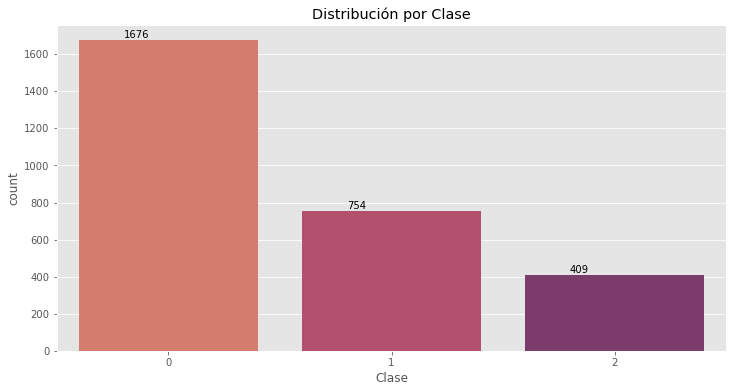

In [107]:
plt.style.use('ggplot')
Frecuencia = Prac.groupby('Clase').sum()
plt.figure(figsize=(12,6))
graf = sns.countplot(Prac['Clase'],palette='flare')
plt.title('Distribución por Clase')
for p in graf.patches:
    graf.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', color='black', size=10)
plt.show()

In [108]:
X = np.array(Prac.drop(['Clase','Prácticas'],1))
Y = np.array(Prac['Clase'])
feature_names = Prac.drop([ 'Clase','Prácticas'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
feature_names

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


array(['O_88', 'O_89', 'O_24', 'O_48', 'O_52', 'O_54', 'O_58', 'O_59',
       'O_90', 'O_28_1', 'O_28_2', 'O_28_3', 'O_28_4', 'O_28_5', 'O_28_6',
       'O_28_7', 'O_28_8', 'O_37_1', 'O_37_2', 'O_37_3', 'O_37_4',
       'O_37_5', 'O_38_1', 'O_38_2', 'O_38_3', 'O_38_4', 'O_38_5',
       'O_38_6', 'O_38_7', 'O_38_8', 'O_38_9', 'O_66_1', 'O_66_2',
       'O_66_3', 'O_66_4', 'O_66_5', 'O_66_6', 'O_66_7', 'O_81_1',
       'O_81_2', 'O_81_3', 'O_81_4', 'O_81_5', 'O_81_6', 'O_81_7',
       'O_82_1', 'O_82_2', 'O_82_3', 'O_82_4', 'O_82_5', 'O_82_6',
       'O_82_7'], dtype=object)

In [109]:
ordinalEncoder = OrdinalEncoder(categories="auto",dtype=np.float64)

ordinalEncoder.fit(X)

X = ordinalEncoder.transform(X)

In [110]:
X = pd.DataFrame(X, columns=feature_names)

In [111]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [112]:
rfc = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=skf, verbose=1, n_jobs=-1).fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [113]:
print("Mejores parámetros", gs_rfc.best_params_)
print("Mejor estimador", gs_rfc.best_estimator_)

Mejores parámetros {'max_features': 'auto', 'n_estimators': 500}
Mejor estimador RandomForestClassifier(class_weight='balanced', n_estimators=500)


In [114]:
rfc = RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=500)

rfc.fit(X_train,y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_pred

array([0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0,
       2, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,

In [115]:
matriz_rfc = confusion_matrix(y_test, rfc_y_pred)
print('Matriz de Confusión:')
print(matriz_rfc)

Matriz de Confusión:
[[484   6   3]
 [ 33 201   1]
 [  6   3 115]]


Text(0.5, 24.0, 'Predicción')

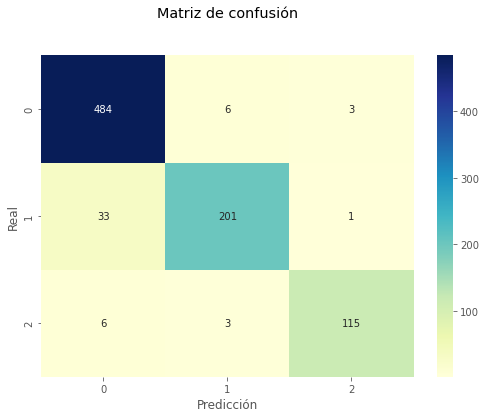

In [116]:
plt.rcParams["figure.figsize"] = (7, 5)
sns.heatmap(pd.DataFrame(matriz_rfc), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [117]:
precision_rfc = precision_score(y_test, rfc_y_pred,average='micro')
print('Precisión del modelo:')
print(precision_rfc)

accuracy_rfc = accuracy_score(y_test, rfc_y_pred)
print('Exactitud del modelo:')
print(accuracy_rfc)

Precisión del modelo:
0.9389671361502347
Exactitud del modelo:
0.9389671361502347


In [118]:
clas_rfc = classification_report(y_test, rfc_y_pred, zero_division = 1)
print(clas_rfc)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       493
           1       0.96      0.86      0.90       235
           2       0.97      0.93      0.95       124

    accuracy                           0.94       852
   macro avg       0.95      0.92      0.93       852
weighted avg       0.94      0.94      0.94       852



In [119]:
rfc.feature_importances_

array([0.00500367, 0.00306867, 0.01145486, 0.00420927, 0.01190398,
       0.00589252, 0.01101765, 0.00849166, 0.01089014, 0.02842902,
       0.038213  , 0.04818517, 0.05442476, 0.03825236, 0.06795781,
       0.03353728, 0.00026466, 0.00221472, 0.00279045, 0.0016205 ,
       0.00070511, 0.00925258, 0.00642715, 0.00546355, 0.00668437,
       0.00344399, 0.00552295, 0.00708279, 0.00391577, 0.00861685,
       0.00243871, 0.00982186, 0.00325655, 0.00634478, 0.0075576 ,
       0.00693689, 0.0088879 , 0.00184587, 0.07318466, 0.05006087,
       0.07191728, 0.09116027, 0.03463838, 0.05582442, 0.03702877,
       0.00976606, 0.01931104, 0.01267688, 0.01426439, 0.01032859,
       0.01122232, 0.01658864])

Text(0.5, 0, 'Random Forest Feature Importance')

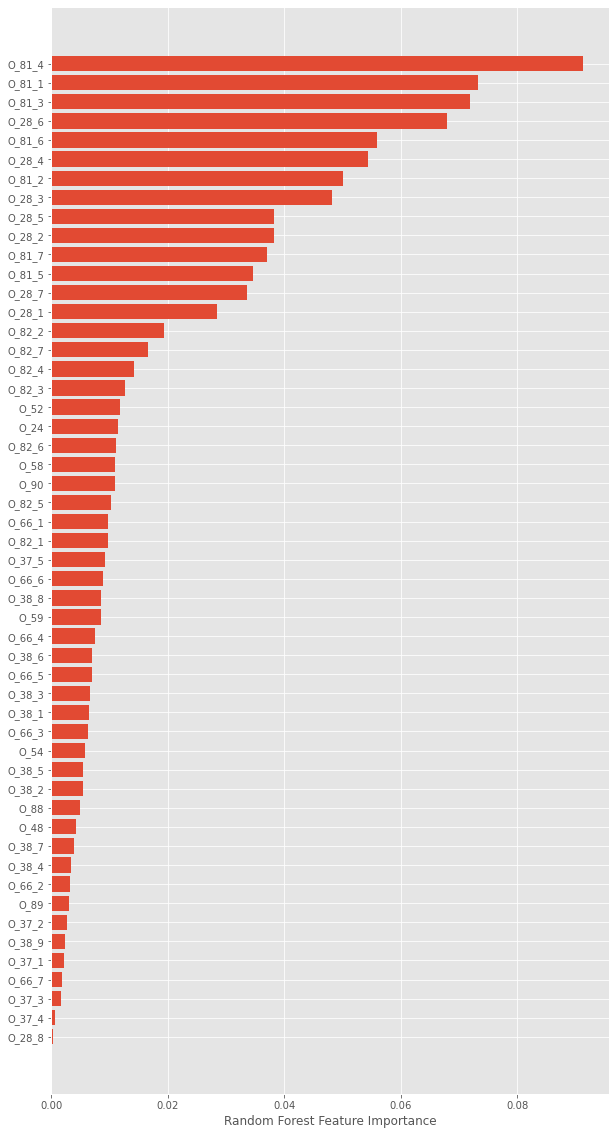

In [120]:
plt.rcParams["figure.figsize"] = (10, 20)
variables_importantes = rfc.feature_importances_.argsort()
plt.barh(feature_names[variables_importantes], rfc.feature_importances_[variables_importantes])
plt.xlabel("Random Forest Feature Importance")

In [121]:
perm_importance = permutation_importance(rfc, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

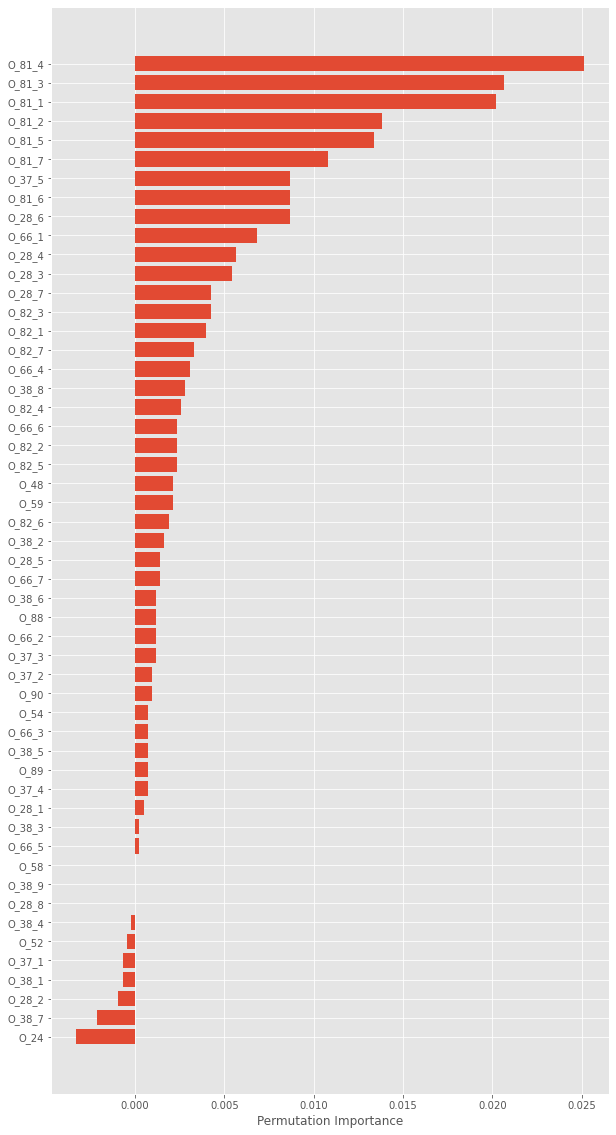

In [122]:
Variables_permutadas = perm_importance.importances_mean.argsort()
plt.barh(feature_names[Variables_permutadas], perm_importance.importances_mean[Variables_permutadas])
plt.xlabel("Permutation Importance")

In [123]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

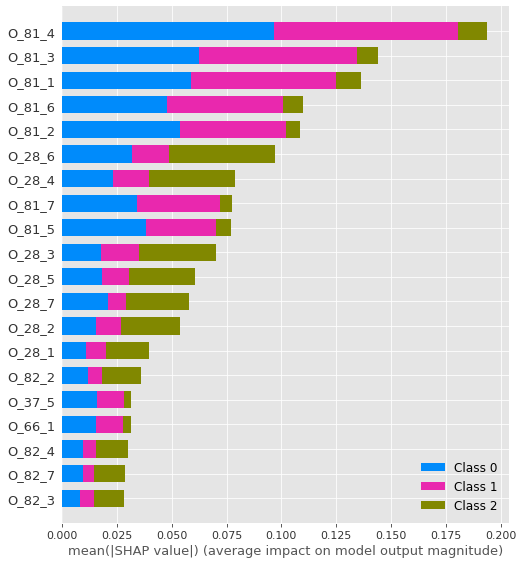

In [124]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

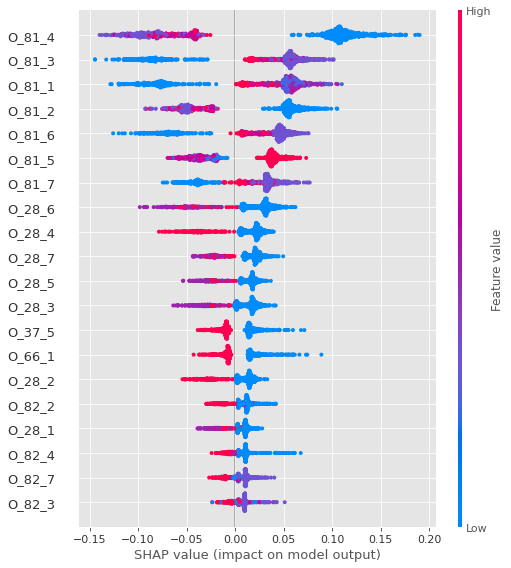

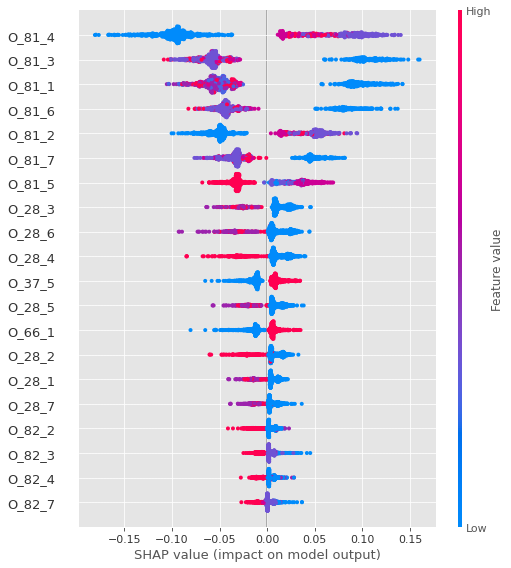

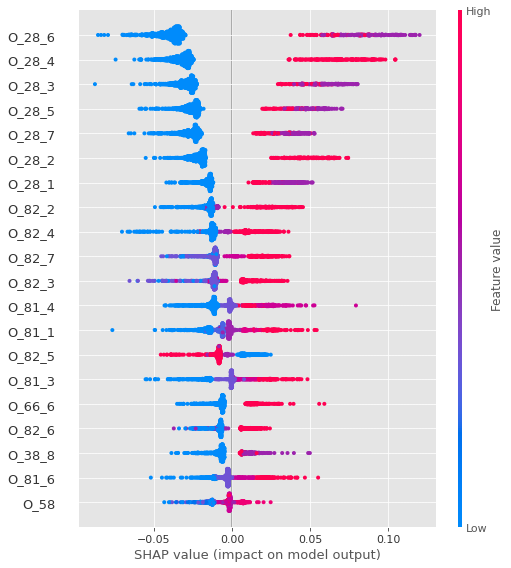

In [125]:
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[2], X_test)

In [126]:
Efectos = Organizaciones[["O_88","O_89",
               "O_40","O_41","O_45","O_49","O_55","O_61_1","O_61_2","O_61_3","O_61_4","O_61_5","O_62_1","O_62_2","O_62_3","O_62_4","O_62_5","O_62_6",
                 'Efectos']]
Efectos

,O_88,O_89,O_40,O_41,O_45,O_49,O_55,O_61_1,O_61_2,O_61_3,O_61_4,O_61_5,O_62_1,O_62_2,O_62_3,O_62_4,O_62_5,O_62_6,Efectos
0,Hombre,Si,"Si, bajo",Positiva,Mejorado,0,0,Equitativo,Equitativo,Equitativo,Equitativo,Equitativo,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.776280663490202
1,Mujer,No,"Si, medio",Positiva,Permanecen igual,0,0,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.720852128598259
2,Hombre,No,"Si, alto",Positiva,Empeorado,70,100,Totalmente inequitativo,Totalmente inequitativo,Totalmente inequitativo,Totalmente inequitativo,Totalmente inequitativo,Totalmente equitativo,Totalmente equitativo,Totalmente equitativo,Totalmente equitativo,Totalmente equitativo,Totalmente equitativo,0.230637284918409
3,Mujer,No,"Si, alto",Positiva,Permanecen igual,30,150,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.560333871978216
4,Mujer,Si,"Si, medio",Positiva,Permanecen igual,40,0,Neutral,Neutral,Inequitativo,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,0.639017842331856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,Hombre,Si,"Si, alto",Positiva,Mejorado,0,0,Neutral,Neutral,Neutral,Neutral,Neutral,Sin registro,Sin registro,Sin registro,Sin registro,Sin registro,Sin registro,0.78577566495339
2835,Hombre,No,"Si, alto",Positiva,Permanecen igual,0,0,Equitativo,Neutral,Inequitativo,Inequitativo,Equitativo,Neutral,Sin registro,Neutral,Neutral,Neutral,Equitativo,0.751619954935751
2836,Hombre,Si,"Si, alto",Positiva,Permanecen igual,0,0,Neutral,Equitativo,Equitativo,Equitativo,Equitativo,Neutral,Sin registro,Neutral,Neutral,Equitativo,Neutral,0.770080907427047
2837,Mujer,Si,"Si, alto",Positiva,Permanecen igual,0,0,Inequitativo,Neutral,Inequitativo,Inequitativo,Inequitativo,Neutral,Sin registro,Neutral,Equitativo,Equitativo,Equitativo,0.743598083280629


In [127]:
Efec = np.array(Efectos.drop(['Efectos'],1))
feature_names = Efectos.drop(['Efectos'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
ordinalEncoder = OrdinalEncoder(categories="auto", dtype=np.float64)
ordinalEncoder.fit(Efec)
Efec = ordinalEncoder.transform(Efec)
Efec = pd.DataFrame(Efec, columns=feature_names)
Efec['Efectos'] = Efectos['Efectos'].astype(float)
Efec['Efectos'] = Efec['Efectos'].replace(np.nan, 0.0, regex=True)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [128]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(Efec.iloc[:,1:])
Efec["Clase"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 759, cost: 19009.0
Run 1, iteration: 2/100, moves: 0, cost: 19009.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 616, cost: 20097.0
Run 2, iteration: 2/100, moves: 494, cost: 18977.0
Run 2, iteration: 3/100, moves: 213, cost: 18977.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 725, cost: 19036.0
Run 3, iteration: 2/100, moves: 116, cost: 19036.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 941, cost: 22334.0
Run 4, iteration: 2/100, moves: 0, cost: 22334.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1251, cost: 20378.0
Run 5, iteration: 2/100, moves: 576, cost: 18977.0
Run 5, iteration: 3/100, moves: 197, cost:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


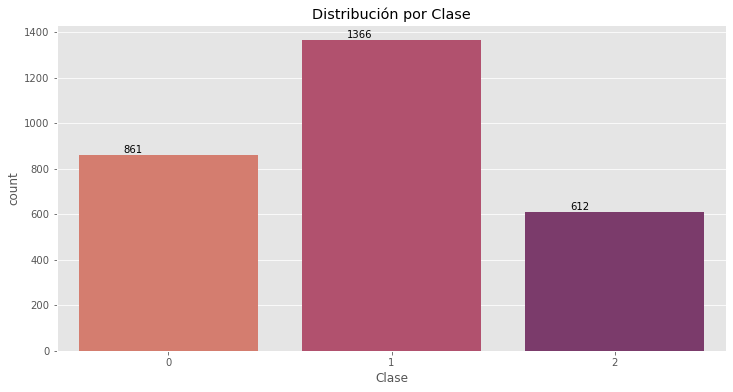

In [129]:
plt.style.use('ggplot')
Frecuencia = Efec.groupby('Clase').sum()
plt.figure(figsize=(12,6))
graf = sns.countplot(Efec['Clase'],palette='flare')
plt.title('Distribución por Clase')
for p in graf.patches:
    graf.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', color='black', size=10)
plt.show()

In [130]:
X = np.array(Efec.drop(['Clase','Efectos'],1))
Y = np.array(Efec['Clase'])
feature_names = Efec.drop([ 'Clase','Efectos'],1)
feature_names = feature_names.columns
feature_names = np.array(feature_names)
feature_names

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


array(['O_88', 'O_89', 'O_40', 'O_41', 'O_45', 'O_49', 'O_55', 'O_61_1',
       'O_61_2', 'O_61_3', 'O_61_4', 'O_61_5', 'O_62_1', 'O_62_2',
       'O_62_3', 'O_62_4', 'O_62_5', 'O_62_6'], dtype=object)

In [131]:
ordinalEncoder = OrdinalEncoder(categories="auto",dtype=np.float64)

ordinalEncoder.fit(X)

X = ordinalEncoder.transform(X)

In [132]:
X = pd.DataFrame(X, columns=feature_names)

In [133]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [134]:
rfc = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs_rfc = GridSearchCV(rfc, param_grid, cv=skf, verbose=1, n_jobs=-1).fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [135]:
print("Mejores parámetros", gs_rfc.best_params_)
print("Mejor estimador", gs_rfc.best_estimator_)

Mejores parámetros {'max_features': 'auto', 'n_estimators': 700}
Mejor estimador RandomForestClassifier(class_weight='balanced', n_estimators=700)


In [136]:
rfc = RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=700)

rfc.fit(X_train,y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_pred

array([1, 0, 1, 1, 2, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1,
       1, 2, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0, 1, 2, 1,
       2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 0, 1, 1, 2,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1,
       2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 2,
       2, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1,

In [137]:
matriz_rfc = confusion_matrix(y_test, rfc_y_pred)
print('Matriz de Confusión:')
print(matriz_rfc)

Matriz de Confusión:
[[247   7   0]
 [ 10 410   1]
 [  3  13 161]]


Text(0.5, 24.0, 'Predicción')

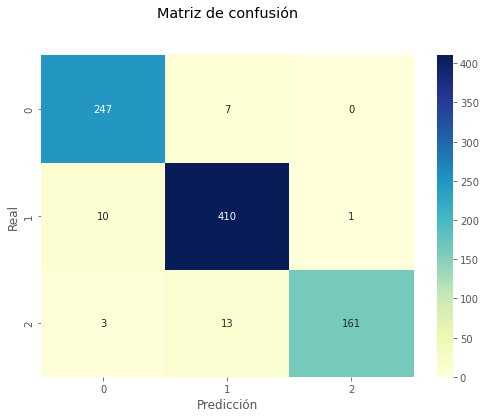

In [138]:
plt.rcParams["figure.figsize"] = (7, 5)
sns.heatmap(pd.DataFrame(matriz_rfc), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Real')
plt.xlabel('Predicción')

In [139]:
precision_rfc = precision_score(y_test, rfc_y_pred,average='micro')
print('Precisión del modelo:')
print(precision_rfc)

accuracy_rfc = accuracy_score(y_test, rfc_y_pred)
print('Exactitud del modelo:')
print(accuracy_rfc)

Precisión del modelo:
0.960093896713615
Exactitud del modelo:
0.960093896713615


In [140]:
clas_rfc = classification_report(y_test, rfc_y_pred, zero_division = 1)
print(clas_rfc)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       254
           1       0.95      0.97      0.96       421
           2       0.99      0.91      0.95       177

    accuracy                           0.96       852
   macro avg       0.97      0.95      0.96       852
weighted avg       0.96      0.96      0.96       852



In [141]:
rfc.feature_importances_

array([0.0079296 , 0.00427143, 0.02749955, 0.00401493, 0.02039363,
       0.01590728, 0.01413   , 0.09460211, 0.10644533, 0.09227519,
       0.14306075, 0.0938043 , 0.04653218, 0.05595546, 0.06830571,
       0.09035074, 0.06699828, 0.04752354])

Text(0.5, 0, 'Random Forest Feature Importance')

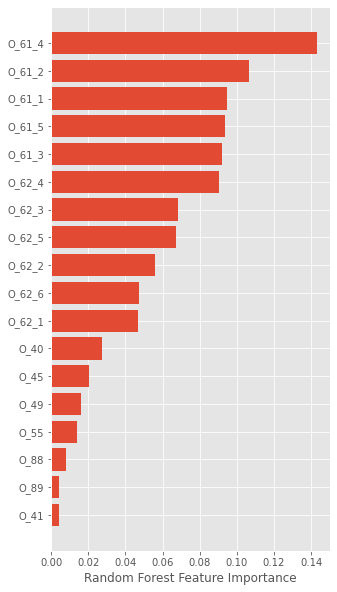

In [142]:
plt.rcParams["figure.figsize"] = (5, 10)
variables_importantes = rfc.feature_importances_.argsort()
plt.barh(feature_names[variables_importantes], rfc.feature_importances_[variables_importantes])
plt.xlabel("Random Forest Feature Importance")

In [143]:
perm_importance = permutation_importance(rfc, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

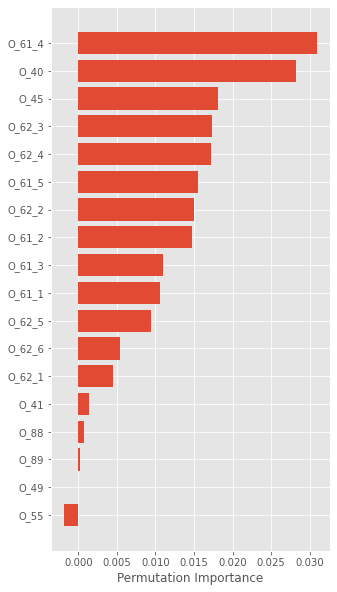

In [144]:
Variables_permutadas = perm_importance.importances_mean.argsort()
plt.barh(feature_names[Variables_permutadas], perm_importance.importances_mean[Variables_permutadas])
plt.xlabel("Permutation Importance")

In [145]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

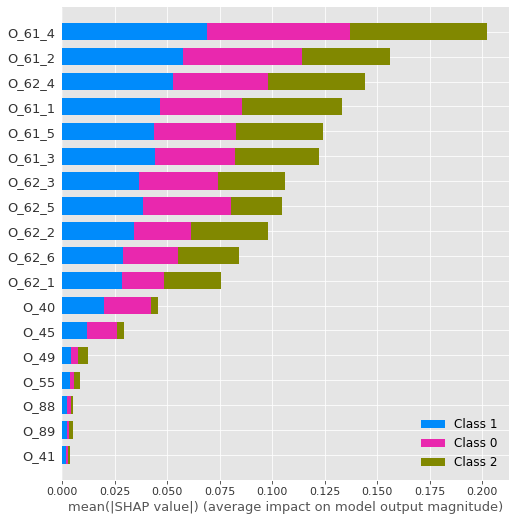

In [146]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

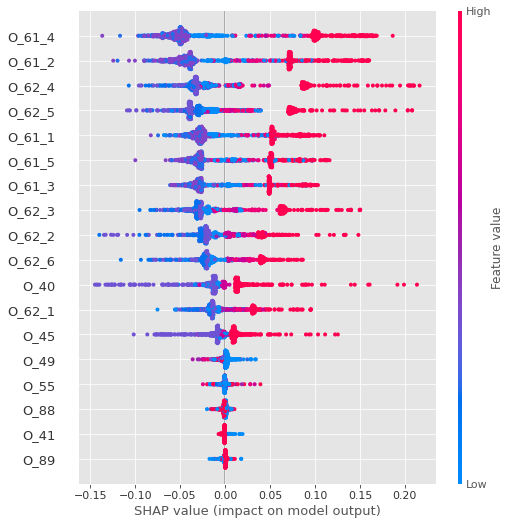

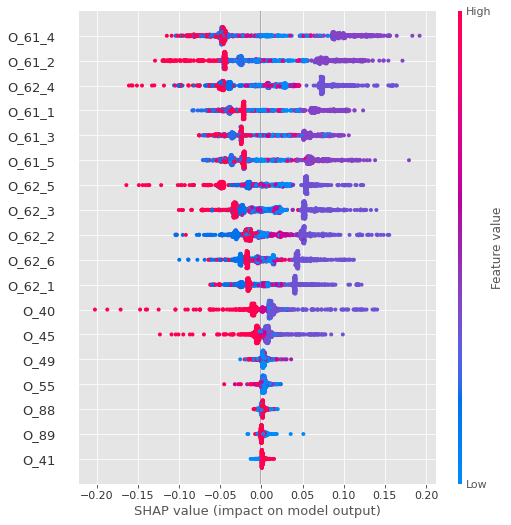

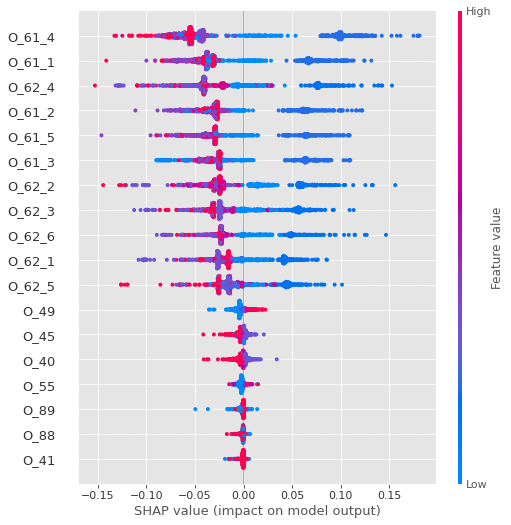

In [147]:
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[2], X_test)